# Variational AutoEncoder in Pytorch

For today's quick project, we're going to reproduce a classic unsuperviser network in Pytorch.

## Recipe difficulty:

* Statistics: 🔥🔥🔥 - you don't need any specific knowledge, but you need to grasp the concept of latent gaussians. 
* Technical: 🔥 - nothing wild here, and in fact the network is so small you don't even need CUDA
* Time required: 🕜 - training iterations are fast, and the code is short and to the point. It took me 83 minutes total to write this.

## What it is

The statistical intuition between a VAE which is actually quite straightforward: we use an **encoder** network to 'compress' image data down to two (or more) N-dimensional vectors, which represent an array of scale and distribution parameters from a distribution of choice (typically a Gaussian).

A **decoder** network is then used to translate this set of latent distributions back to an image.

The encoder and the decoder are jointly optimized using a simple **mean square error between the ground truth and reconstructed** pixels. This is the first half of the loss function. 

The second part of the loss function is the **Kullback-Leibler divergence**, which can be seen as a regularization term between our latent set of distributions and a set of gaussians. This is to make sure that all latent sampled are coming from the same distribution (i.e. we want our set of 20 sampled parameters to be probabilistically close to the 'true' mu and sigma in the sample space.

As usual, this is by no mean an exhaustive explanation - [Kevin Frans' amazing blogpost](http://kvfrans.com/variational-autoencoders-explained/) is a good starting point if you want to know more.

## Why it is useful

A VAE is a fully unsupervised dimensionality reduction method. It can be useful, for instance, to reduce related data down to a more manageable number of variables, without needing any labelling work.

Note that VAEs can also work on non-image data!

Finally, they are the easiest to grasp out of all generative models. In this post I'll show how to sample the latent distribution to generate completely new data

We start with the usual imports. I'm using Pytorch here, as it allows for a more understandable joint optimization than say, Keras. 

In [13]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

%matplotlib inline

GPU = True

if not torch.cuda.is_available():
    print('no GPU detected, check CUDA install')
    GPU = False

We use Fashion MNIST, which is a more interesting drop-in replacement for the classic MNIST digits dataset as our image source.

In [38]:
trans = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.FashionMNIST('day1/data', download=True, 
                                            transform=trans)
dataset
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

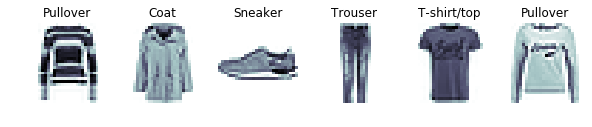

In [39]:
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
           'Sandal','Shirt','Sneaker','Bag','Ankle boot']

fig, axes = plt.subplots(1,6, figsize=(10,2))
for ax in axes.ravel():
    r= iter(dataloader).next()
    ax.imshow(r[0].numpy()[1].reshape(28,28), cmap='bone_r')
    ax.set_title(classes[r[1].numpy()[1]])
    ax.axis('off')

VAE is our Variational Autoencoder network.
It uses a simple set of linear activations, with input and output equal to the flattened image (28x28 pixels = 784), and a set of 20 activation parameters for both mu and sigma. The latter is supposed to be a logarithmic variable, since there can be no negative scale parameter.

* The **encode** function reduces the input image to a set of 20 location (mu) and 20 scale (sigma) parameters
* The **parametric** function uses these parameter to generate a vector of 20 samples.
* The **decode** function projects the samples back into the image space.

In [40]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input_layer = nn.Linear(784, 400)
        self.mu = nn.Linear(400, 20)
        self.sigma = nn.Linear(400, 20)
        
        self.upscale_sample = nn.Linear(20, 400)
        self.output_layer = nn.Linear(400, 784)
        
    def encode(self, x):
        x = F.relu(self.input_layer(x))
        return self.mu(x), self.sigma(x)
    
    def parametric(self, mu, sigma):
        # A gaussian with
        # mu mean between 0 and inf
        # sigma std between 0 and inf
        
        std = sigma.exp()
        if GPU:
            sample = torch.cuda.FloatTensor(mu.size()).normal_()
        else:
            sample = torch.FloatTensor(mu.size()).normal_()
            
        sample = Variable(sample)
        return sample.mul(std).add(mu)
    
    def decode(self, sample):
        x = F.relu(self.upscale_sample(sample))
        return torch.sigmoid(self.output_layer(x))
    
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        sample = self.parametric(mu, sigma)
        return self.decode(sample), mu, sigma

In [41]:
model = VAE()

if GPU:
    model.cuda()

The loss function is, as mentioned, the sum of a mean squared error and the KL divergence.

For the standard normal case, the KL divergence reduces to the below equation. I have derived this back when I studied statistics, but nowadays I just trust the result :)

In [42]:
def loss_function(reconstructed, ground_truth, mu, sigma):
    image_loss = nn.MSELoss(reduction='sum')(reconstructed, ground_truth)
    KL_divergence_loss = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    return image_loss, KL_divergence_loss


optimizer = optim.Adam(model.parameters(), lr=1e-3)

The model stops improving after around 20 epochs.

The key steps here are, as typical for Pytorch (but more involved from people coming from Sklearn or Keras), that you:

* zero-out the gradient from your optimizer 
* you calculate the loss function based on input and output from your model
* you do a .backward() step on the loss for backprop
* you move on to the next step

In [45]:
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss_im, train_loss_kl = 0, 0
    for batch_id, data in enumerate(dataloader):
        img, _ = data
        # reshape
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if GPU:
            img = img.cuda()
        
        optimizer.zero_grad()
        batch, mu, sigma = model(img)
        loss_im, loss_kl = loss_function(batch, img, mu, sigma)
        loss = loss_im + loss_kl
        loss.backward()
        optimizer.step()
        
        train_loss_im += loss_im
        train_loss_kl += loss_kl
       
    print('====> Epoch: {} Average KL loss: {:.4f}, Average MSE loss: {:.4f}, Average loss: {:.4f}'.format(
    epoch, train_loss_im / len(dataloader.dataset), 
        train_loss_kl / len(dataloader.dataset), (train_loss_im+train_loss_kl)/ len(dataloader.dataset)))

====> Epoch: 0 Average KL loss: 472.3373, Average MSE loss: 6.8929, Average loss: 479.2302
====> Epoch: 1 Average KL loss: 471.4956, Average MSE loss: 6.8626, Average loss: 478.3582
====> Epoch: 2 Average KL loss: 470.7567, Average MSE loss: 6.8633, Average loss: 477.6199
====> Epoch: 3 Average KL loss: 470.1885, Average MSE loss: 6.8936, Average loss: 477.0821
====> Epoch: 4 Average KL loss: 469.6948, Average MSE loss: 6.8892, Average loss: 476.5840
====> Epoch: 5 Average KL loss: 469.2154, Average MSE loss: 6.9267, Average loss: 476.1422
====> Epoch: 6 Average KL loss: 468.8340, Average MSE loss: 6.9498, Average loss: 475.7838
====> Epoch: 7 Average KL loss: 468.5081, Average MSE loss: 6.9733, Average loss: 475.4815
====> Epoch: 8 Average KL loss: 468.2431, Average MSE loss: 6.9910, Average loss: 475.2341
====> Epoch: 9 Average KL loss: 467.9756, Average MSE loss: 7.0138, Average loss: 474.9893


The model reconstructs the original inputs decently:

[]

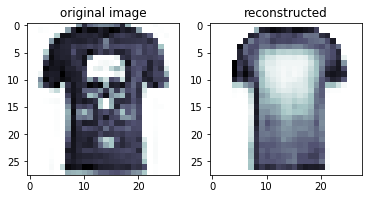

In [78]:
model.eval()
ev_img = iter(dataloader).next()[0].numpy()[1].reshape(28,28)
ev_img_r = ev_img.ravel()

ev_mu, ev_sigma = model.encode(torch.from_numpy(ev_img_r).cuda())
ev_param_tensor = model.parametric(ev_mu,ev_sigma)
ev_out = model.decode(ev_param_tensor).cpu().detach().numpy().reshape(28,28)

fig, ax = plt.subplots(1,2)
ax[0].set_title('original image')
ax[0].imshow(ev_img, cmap='bone_r')
ax[1].set_title('reconstructed')
ax[1].imshow(ev_out, cmap='bone_r')
plt.plot()

As a bonus, we can just sample from the full distribution to create new clothes!

In [109]:
def generate_with_offset(x):
    ev_mu_sl = ev_mu.add(x)
    ev_param_tensor = model.parametric(ev_mu_sl,ev_sigma)
    ev_out = model.decode(ev_param_tensor).cpu().detach().numpy().reshape(28,28)
    return ev_out
    
generative_clothes = [generate_with_offset(i) for i in np.arange(-.5,3,.25)]

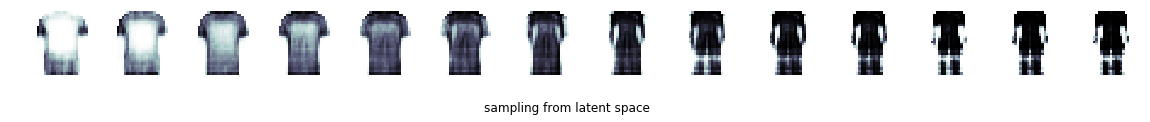

In [114]:
fig, axes = plt.subplots(1,len(generative_clothes), figsize=(20,4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(generative_clothes[i], cmap='bone_r')
    ax.axis('off')
plt.suptitle('sampling from latent space', y=.3)
plt.show()

If you're running a live notebook, using the slider is quite an interesting experience!

In [115]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def slide_f(x):
    plt.figure(figsize=(2,2))
    ev_mu_sl = ev_mu.add(x)
    ev_param_tensor = model.parametric(ev_mu_sl,ev_sigma)
    ev_out = model.decode(ev_param_tensor).cpu().detach().numpy().reshape(28,28)
    plt.imshow(ev_out, cmap='bone_r')


interact(slide_f, x=(0, 3.0, 0.02))

interactive(children=(FloatSlider(value=1.5, description='x', max=3.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.slide_f(x)>

And that's all for today!